<a href="https://colab.research.google.com/github/Shkum/IT_STEP/blob/ML/NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [112]:
import pandas as pd
import torch

In [113]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані про морське вухо(молюск)

<div>
<img src="https://m.media-amazon.com/images/I/81-FC5TlLtL.jpg" width="500"/>
</div>

In [114]:
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/abalone.csv')
df.drop(columns=['Type', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight'], inplace=True)

In [115]:
df.head()

,LongestShell,Diameter,Height,Rings
0,0.455,0.365,0.095,15
1,0.350,0.265,0.090,7
2,0.530,0.420,0.135,9
3,0.440,0.365,0.125,10
4,0.330,0.255,0.080,7


In [116]:
df.columns = df.columns.str.lower()

In [117]:
df.head(2)

,longestshell,diameter,height,rings
0,0.455,0.365,0.095,15
1,0.350,0.265,0.090,7


Потрібно на основі розмірів молюска спрогнозувати кількість кілець в мушлі `Rings`. Використовуйте процесор cpu

# Завдання 1
Створіть клас Dataset

In [118]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X).to(device)
        self.y = torch.FloatTensor(y).to(device)
        self.y = self.y.reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['rings']).to_numpy()
y = df['rings'].to_numpy()

dataset = MyDataset(X, y)

# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [119]:
from torch.utils.data import DataLoader

batch_size = 128
dataloader = DataLoader(dataset,  # датасет з даними
                        batch_size=batch_size,  # кількість даних в одному пакеті
                        shuffle=True,  # чи треба перемішувати дані
                        generator=torch.Generator(device=device)) # підключення до процесора)

# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-3
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [120]:
from torch import nn


model = nn.Sequential(
          nn.Linear(3, 10),
          nn.ReLU(),
          nn.Linear(10, 5),
          nn.ReLU(),
          nn.Linear(5, 5),
          nn.ReLU(),
          nn.Linear(5, 5),
          nn.ReLU(),
          nn.Linear(5, 1),
        )

model

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=5, bias=True)
  (7): ReLU()
  (8): Linear(in_features=5, out_features=1, bias=True)
)

In [121]:
from torchsummary import summary

summary(model, input_size=(3,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              40
              ReLU-2                   [-1, 10]               0
            Linear-3                    [-1, 5]              55
              ReLU-4                    [-1, 5]               0
            Linear-5                    [-1, 5]              30
              ReLU-6                    [-1, 5]               0
            Linear-7                    [-1, 5]              30
              ReLU-8                    [-1, 5]               0
            Linear-9                    [-1, 1]               6
Total params: 161
Trainable params: 161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------

# Завдання 4
Визначте функцію втрат та оптимізатор

In [122]:
# Функція втрат середньоквадратичної помилки (MSE) для регресії
loss_fn = nn.MSELoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [123]:
%%time
import numpy as np

num_epochs = 200
losses = []

for epoch in range(num_epochs):
    losses_ = []
    for X_batch, y_batch in dataloader:
        # пряме пошерення
        prediction = model(X_batch)
        loss = loss_fn(prediction, y_batch)
        losses_.append(loss.item())

        # Зворотнє поширення
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(np.mean(losses_)**0.5)

CPU times: user 20.1 s, sys: 222 ms, total: 20.3 s
Wall time: 20.7 s


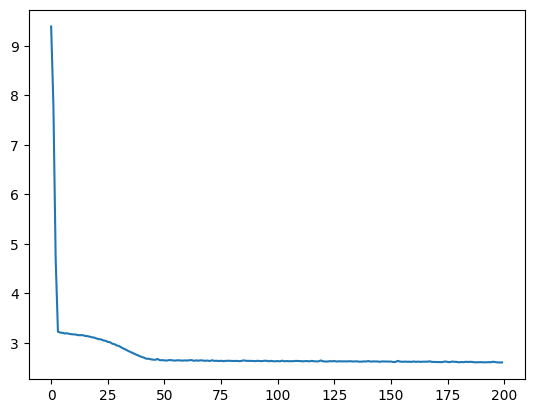

In [124]:
import matplotlib.pyplot as plt

plt.plot(losses)
#plt.ylim(0, 0.2*1e8)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [125]:
torch.save(model, 'model.pt')

In [126]:
load_model = torch.load('model.pt')

In [127]:
load_model

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=5, bias=True)
  (7): ReLU()
  (8): Linear(in_features=5, out_features=1, bias=True)
)

In [128]:
X_data = torch.Tensor(np.array(X[[0]]))
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.4550, 0.3650, 0.0950]])
torch.Size([1, 3])


In [129]:
load_model(X_data) # порахує грабієнти

tensor([[8.6361]], grad_fn=<AddmmBackward0>)

In [130]:
with torch.no_grad(): # без градієнтів
  print(load_model(X_data))

tensor([[8.6361]])


In [131]:
df.head(1)

,longestshell,diameter,height,rings
0,0.455,0.365,0.095,15
